# Assignment 2: Let’s go to Monte Carlo

## Submitted By: Aarathi Vijayachandran (244267)

### Assignment question is available here: https://ovgu-ailab.github.io/lgm2024/assignment2.html

## PART - 1: Markov Chain Monte Carlo

In [14]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions

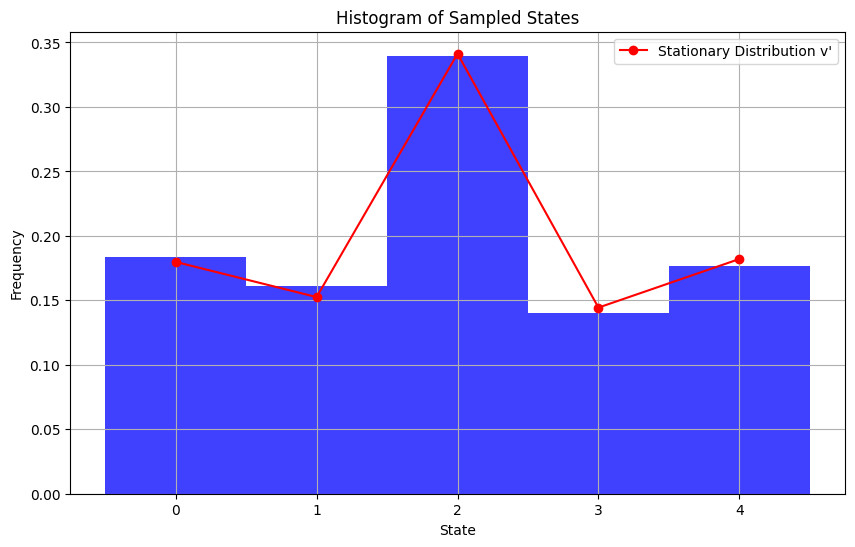

In [25]:
# Size of the A matrix
n = 5

# Create a stochastic transition matrix A with no zeros
A_logits = tf.random.normal([n, n])
A = tf.nn.softmax(A_logits, axis=0)  # Softmax to make columns sum to 1

# Create an arbitrary initial distribution v(0) that sums to 1
v = tf.random.uniform([n])
v0 = v / tf.reduce_sum(v)

# Matrix multiplication to find the stationary distribution
v_old = v0
for _ in range(100):  # Iterate to reach convergence
    v_new = tf.matmul(A, tf.reshape(v_old, [n, 1]))
    v_old = tf.reshape(v_new, [n])

# v' is the stationary distribution after convergence
v_prime = tf.reshape(v_old, [n])

# Running the Markov chain to sample states
current_state = np.random.choice(n)  # Start from an arbitrary state x(0)
samples = []

# Run the chain for a large number of steps
for _ in range(10000):
    # Create a categorical distribution for the current state and sample from it
    probs = A[:, current_state]
    categorical = tfd.Categorical(probs=probs)
    next_state = categorical.sample().numpy()

    # Append sampled state and update current state
    samples.append(next_state)
    current_state = next_state

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=np.arange(n+1)-0.5, density=True, alpha=0.75, color='blue')
plt.xticks(np.arange(n))
plt.title("Histogram of Sampled States")
plt.xlabel("State")
plt.ylabel("Frequency")
plt.grid(True)

# Compare with v'
plt.plot(np.arange(n), v_prime.numpy(), 'ro-', label='Stationary Distribution v\'')
plt.legend()
plt.show()


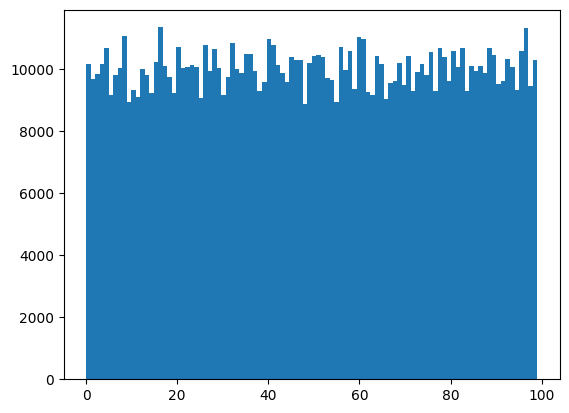

In [23]:
# Creating a transition Matrix A. This is Stochastic matrix ==> Non negative entries and sum of columns = 1
def stochastic_matrix(n):
  matrix = np.random.rand(n,n)

  # Normalising the columns sum to 1
  matrix /= matrix.sum(axis=0, keepdims = True)

  return matrix

# Creating an arbitrary initial distribution v(0)
def initial_distribution(n):
    # Create an n-element vector of random values
    v = np.random.rand(n)

    # Normalize ==> element wise sum =1
    v = v / np.sum(v)

    return v

# SIMPLE MC
n= 100
start_state = 0
Total_samples= [start_state]
no_of_samples = 1000000
no_of_AtimesV= 1000

A = stochastic_matrix(n)
v= initial_distribution(n)

for i in range(no_of_AtimesV):
  V = A@v

current_State =  start_state
for i in range(no_of_samples):
  column = A[:, current_State]
  rand_Index = np.where(np.random.multinomial(1,column))[0][0] ## getting a random nect state
  Total_samples.append(rand_Index)
  current_State = rand_Index

# Plotting
plt.hist(Total_samples, bins = n)
plt.show()

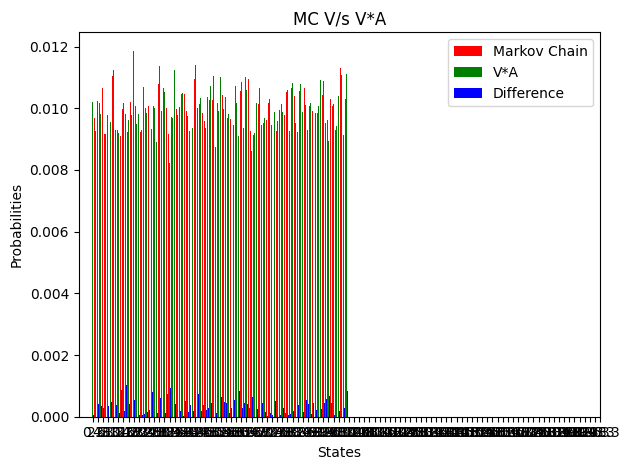

In [24]:
Func_MC = lambda n, Total_samples: np.array([sum(1 for i in Total_samples if i == j) for j in range(n)])

val_MC = Func_MC(n,Total_samples)

# Dividing it by no. of samples
Norm_MC = val_MC/no_of_samples

# Plotting MC, V*A and their Diff
bar_width = 0.30

ind= np.arange(len(Norm_MC))

plt.bar(ind, Norm_MC, bar_width, color='r', label='Markov Chain')
plt.bar(ind + bar_width, V, bar_width, color='g', label = 'V*A')
plt.bar(ind + 2*bar_width, abs(Norm_MC-V), bar_width, color='b', label='Difference')

plt.xlabel('States')
plt.ylabel('Probabilities')
plt.legend()
plt.xticks(ind + bar_width + ind)
plt.title('MC V/s V*A')

plt.tight_layout()
plt.show()


## PART - 2: Gibbs Sampling & Mixing

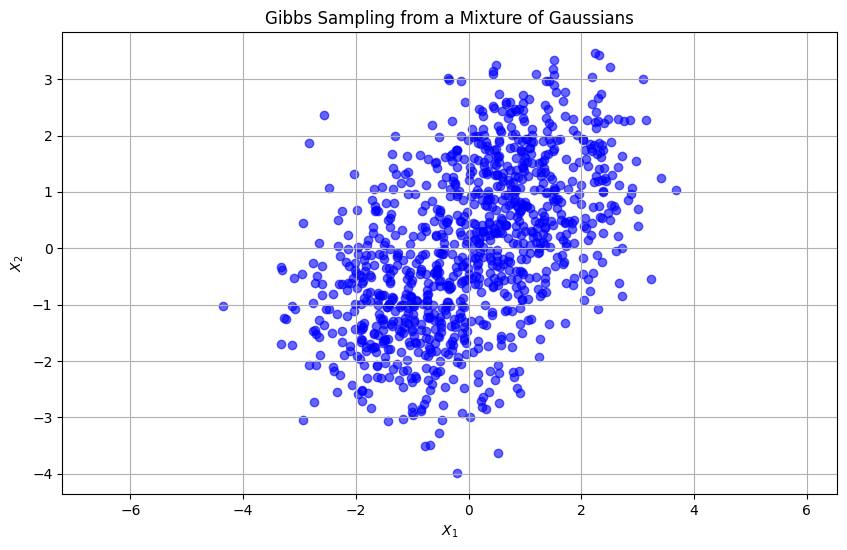

In [18]:
def gibbs_sampling(location, scale, n_samples):
    # Setup initial distribution parameters
    prior_mixture_weights = np.array([0.5, 0.5])

    # Initialize sampling process
    x_samples = np.zeros((n_samples, 2))

    # Start with an arbitrary initial sample
    x_current = np.array([0.0, 0.0])

    for i in range(n_samples):
        # Sample x1 given x2
        mixing_score1 = prior_mixture_weights[0] * tfd.Normal(loc=-location, scale=scale).prob(x_current[1])
        mixing_score2 = prior_mixture_weights[1] * tfd.Normal(loc=location, scale=scale).prob(x_current[1])
        pi1 = mixing_score1 / (mixing_score1 + mixing_score2)
        pi2 = mixing_score2 / (mixing_score1 + mixing_score2)

        conditional_x1 = tfd.MixtureSameFamily(
            tfd.Categorical(probs=[pi1, pi2]),
            tfd.Normal(loc=[-location, location], scale=scale)
        )
        x_current[0] = conditional_x1.sample()

        # Sample x2 given x1
        mixing_score1 = prior_mixture_weights[0] * tfd.Normal(loc=-location, scale=scale).prob(x_current[0])
        mixing_score2 = prior_mixture_weights[1] * tfd.Normal(loc=location, scale=scale).prob(x_current[0])
        pi1 = mixing_score1 / (mixing_score1 + mixing_score2)
        pi2 = mixing_score2 / (mixing_score1 + mixing_score2)

        conditional_x2 = tfd.MixtureSameFamily(
            tfd.Categorical(probs=[pi1, pi2]),
            tfd.Normal(loc=[-location, location], scale=scale)
        )
        x_current[1] = conditional_x2.sample()

        # Store the sample
        x_samples[i] = x_current

    return x_samples

# Parameters for Gaussian components
location = 1.
scale = 1.

# Number of samples to draw
n_samples = 1000

# Run Gibbs sampling
samples = gibbs_sampling(location, scale, n_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, color='blue')
plt.title('Gibbs Sampling from a Mixture of Gaussians')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.axis('equal')
plt.show()


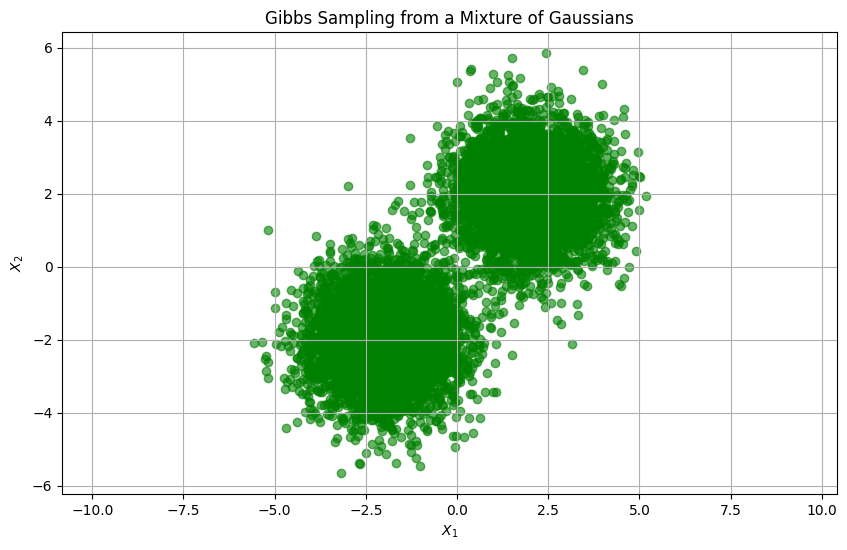

In [10]:
# Parameters for Gaussian components
location = 2
scale = 1

# Number of samples to draw
n_samples = 10000

# Run Gibbs sampling
samples = gibbs_sampling(location, scale, n_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, color='green')
plt.title('Gibbs Sampling from a Mixture of Gaussians')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.axis('equal')
plt.show()

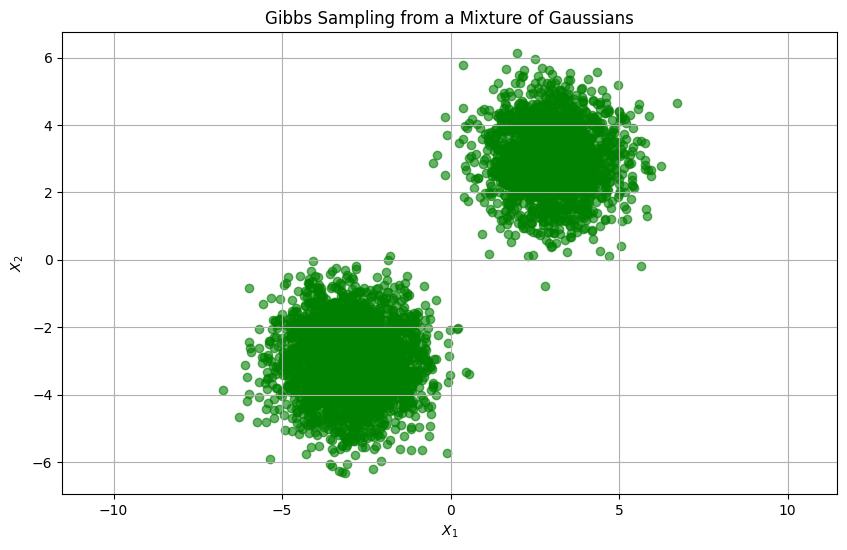

In [12]:
# Parameters for Gaussian components
location = 3
scale = 1

# Number of samples to draw
n_samples = 5000

# Run Gibbs sampling
samples = gibbs_sampling(location, scale, n_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, color='green')
plt.title('Gibbs Sampling from a Mixture of Gaussians')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.axis('equal')
plt.show()

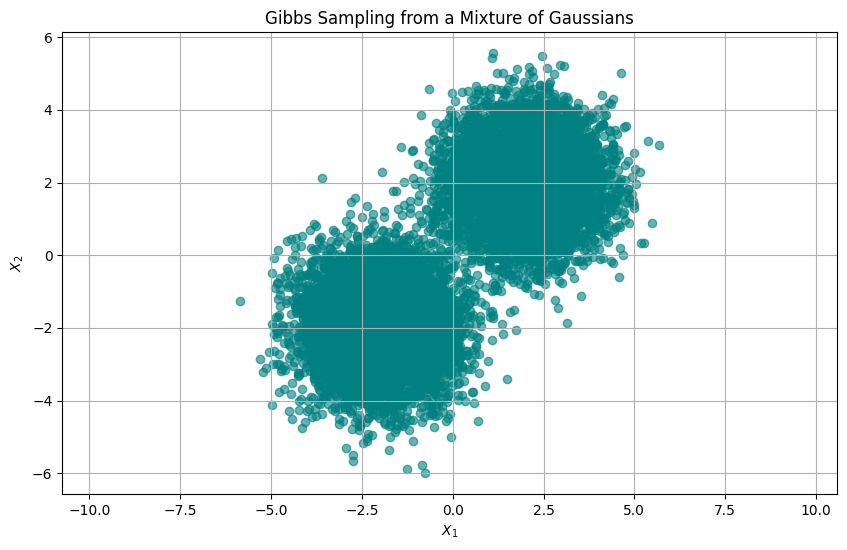

In [13]:
# Parameters for Gaussian components
location = 2
scale = 1

# Number of samples to draw
n_samples = 15000

# Run Gibbs sampling
samples = gibbs_sampling(location, scale, n_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, color='teal')
plt.title('Gibbs Sampling from a Mixture of Gaussians')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.axis('equal')
plt.show()

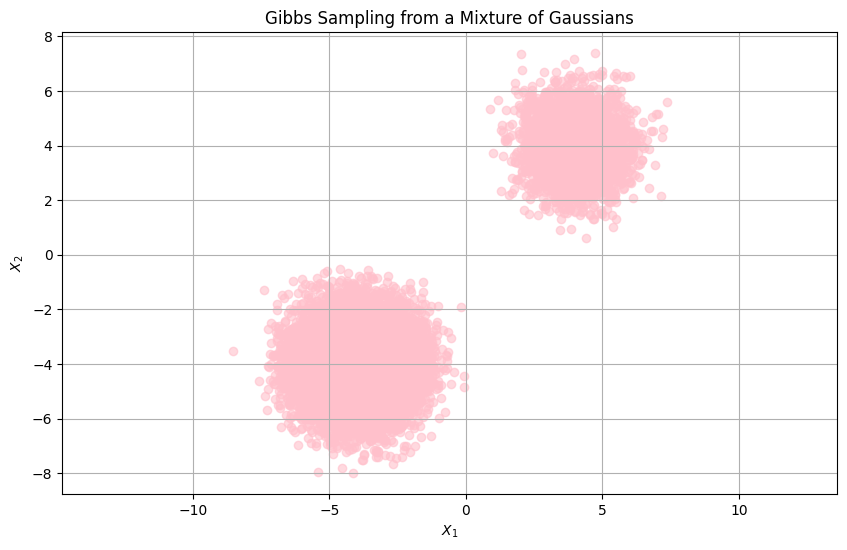

In [26]:
# Parameters for Gaussian components
location = 4
scale = 1

# Number of samples to draw
n_samples = 20000

# Run Gibbs sampling
samples = gibbs_sampling(location, scale, n_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, color='pink')
plt.title('Gibbs Sampling from a Mixture of Gaussians')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.axis('equal')
plt.show()

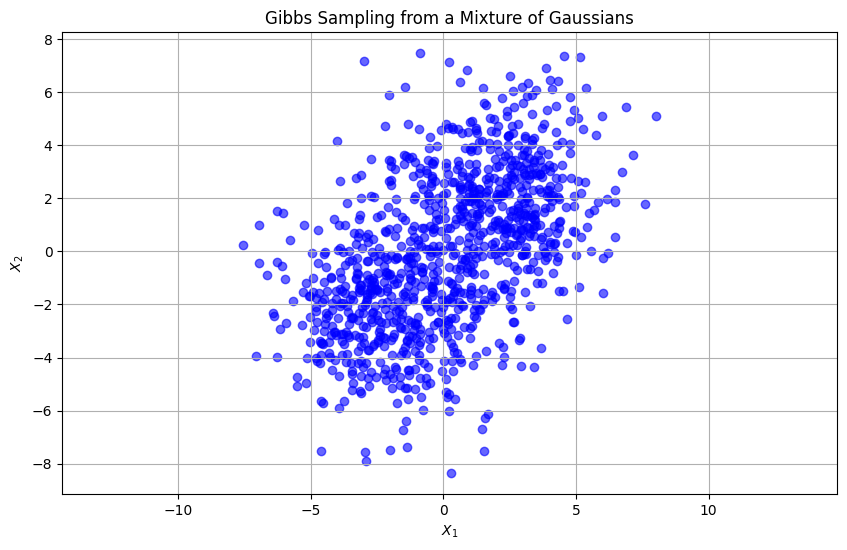

In [27]:
# Parameters for Gaussian components
location = 2
scale = 2

# Number of samples to draw
n_samples = 2000

# Run Gibbs sampling
samples = gibbs_sampling(location, scale, n_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, color='blue')
plt.title('Gibbs Sampling from a Mixture of Gaussians')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.axis('equal')
plt.show()